This notebook post-processes the results from the SFINCS model into maps of maximum water depth in flooded areas (masking permanent water bodies provided a mask is available). Outputs are 
1. Timeseries at observation stations compared against measurements.
2. Flood map with maximum water depth and extent for the event duration.
3. Animated map with time slider. Permanent water bodies not masked yet!
4. Video animation.  

Results are all saved to the simulation folder

In [74]:
from hydromt_sfincs import SfincsModel
import hydromt_sfincs.utils as utils
import numpy as np
from pathlib import Path 
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
import hvplot.xarray
import xarray as xr


USER INPUT

Set the model directory.
Specify the DEM file to produce downscaled water depth maps.  
Provide filename for the output map. 
Water level measurements to compare against model results (received from a local tide gauge). TO DO: replace with automatic download.

In [ ]:
# simulation folder
simulation_path = (
    r"c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_output\SFINCS\model_20m_final_dikes_overtopping_80cm"
)
# DEM file for downscaling
demfile = r"c:\Users\winter_ga\Offline_data\projects\InterTwin\Geodaten\DEM.tif"
# output filename for flood map
floodmap_fn = "max_waterdepth.tif"
# mask for permanent water bodies
land_mask = r"c:\Users\winter_ga\Offline_data\projects\InterTwin\Geodaten\landmask.gpkg"

# water level observations
wl_csv = r"c:\Users\winter_ga\Offline_data\projects\InterTwin\Wasserstaende\waterlevels-20231015-20231023.csv"


Read model results

In [ ]:
# read results
model = SfincsModel(root=simulation_path, mode="r+")
model.read()

model.read_results()

# save station data as csv
df = pd.DataFrame(index=model.results["point_zs"].time.values)
if len(model.results["point_zs"].stations) > 0:
    for ii in np.arange(len(model.results["point_zs"].stations)):
        model.results["point_zs"].isel(stations=ii).to_dataframe().to_csv(
            Path(simulation_path).joinpath(f"station_data_{ii:03d}.csv")
        )
        df[ii] = model.results["point_zs"].isel(stations=ii).values



Import observed water levels 

In [16]:
# read observations
obs_df = pd.read_csv(wl_csv,header=0, delimiter=";")

obs_df["timestamp"] = pd.to_datetime(obs_df["timestamp"])
obs_df = obs_df.set_index("timestamp")

obs_df = obs_df.resample(rule='10min').mean()/100

# obs_df
df

,0,1,2,3,4,5
2023-10-15 07:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-10-15 07:10:00,-0.291206,0.011718,0.005971,-0.007730,-0.000985,-0.002066
2023-10-15 07:20:00,-0.492481,0.004858,0.004102,0.005619,-0.000501,-0.009115
2023-10-15 07:30:00,-0.543393,0.001575,0.001773,-0.000408,-0.002335,-0.011914
2023-10-15 07:40:00,-0.567965,-0.004984,0.005216,-0.011098,-0.005209,0.002632
...,...,...,...,...,...,...
2023-10-22 23:20:00,0.381337,0.505053,0.686221,0.667864,0.667850,0.505055
2023-10-22 23:30:00,0.380780,0.503318,0.684823,0.666494,0.666478,0.503388
2023-10-22 23:40:00,0.381034,0.503249,0.683427,0.665120,0.665113,0.503171
2023-10-22 23:50:00,0.379684,0.502319,0.682038,0.663748,0.663738,0.502201


Plot comparison of observed and modelled water levels

<a list of 3 Line2D objects>


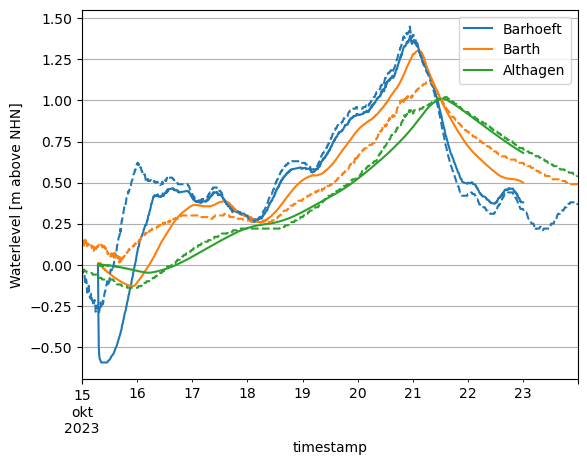

In [43]:

fig, ax = plt.subplots()
df.plot(ax=ax,y=[0,1,2])
clr=[]
print(ax.get_lines())
for n,li in enumerate(ax.get_lines()):
    clr.append(li.get_color())
obs_df.plot(ax=ax, style="--",cmap=ListedColormap(clr))
plt.grid()
# ax.set_ylim(bottom=0)
labels = [str(station).replace(" ", "").replace("b","") for station in model.results["point_zs"].station_name.values]
plt.legend(obs_df.columns.to_list())
ax.set_ylabel("Waterlevel [m above NHN]")

plt.savefig(Path(simulation_path).joinpath("station_data.png"))




Generate downscaled flood map with maximum water depths over event duration 
Use mask if available to mask permanent water bodies.

In [ ]:
# read land mask
gdf_mask = gpd.read_file(land_mask)
# read dem file for high resolution flood depth map
dem = model.data_catalog.get_rasterdataset(demfile)

zsmax = model.results["zsmax"].max(dim="timemax")
zsmax.attrs["units"] = "m"
# writing the geotiff to the scenario results folder, masking permanent water bodies
utils.downscale_floodmap(
    zsmax=zsmax,
    dep=dem,
    hmin=0.01,
    floodmap_fn=str(Path(simulation_path).joinpath(floodmap_fn)),
    gdf_mask = gdf_mask
)



<xarray.DataArray 'hmax' (y: 7400, x: 10410)> Size: 308MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    spatial_ref  int32 4B 0
  * x            (x) float64 83kB 3.208e+05 3.208e+05 ... 3.729e+05 3.729e+05
  * y            (y) float64 59kB 6.011e+06 6.011e+06 ... 6.048e+06 6.048e+06
Attributes:
    _FillValue:  nan
    long_name:   Maximum flood depth
    units:       m

Create timeslider of flood water depth (It's very slow!!!)

In [ ]:

hmin = 0.05
da_h = model.results["h"].copy()
da_h = da_h.where(da_h > hmin).drop("spatial_ref")
da_h.attrs.update(long_name="flood depth", unit="m")

# # mask permanent water bodies -> not working yet
# inifile = r"c:\Users\winter_ga\Offline_data\projects\InterTwin\Geodaten\zsini_regridded_20m_final.tif"
# ini_ds = xr.open_dataset(inifile, engine="rasterio")
# ini_ds["zsini"] = ini_ds["band_data"]
# ini_ds = ini_ds.drop(["band_data","band"])
# id=ini_ds.sel(band=0).where(0,np.nan)

da_h.hvplot.image(
    x="x",
    y="y",
    groupby="time",
    tiles=True,
    cmap="Reds",
    frame_width=400,
    crs=25833
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'a48a9fc0-1f5a-4bfa-b415-867dc5af35d1': {'version…

Create video animation of flooding. This takes a while...

In [ ]:
# create animation
hmin = 0.05
da_h = model.results["h"].copy()
da_h = da_h.where(da_h > hmin).drop("spatial_ref")
da_h.attrs.update(long_name="flood depth", unit="m")
# create hmax plot and save to mod.root/figs/sfincs_h.mp4
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}


def update_plot(i, da_h, cax_h):
    da_hi = da_h.isel(time=i)
    t = da_hi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water depth {t}")
    cax_h.set_array(da_hi.values.ravel())


fig, ax = model.plot_basemap(
    fn_out=None, variable="", bmap="sat", plot_bounds=False, figsize=(11, 7)
)
cax_h = da_h.isel(time=0).plot(
    x="x", y="y", ax=ax, vmin=0, vmax=3, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_h.time.size, step),
    interval=1000,  # ms between frames
    fargs=(
        da_h,
        cax_h,
    ),
)

# to show in notebook:
from IPython.display import HTML

HTML(ani.to_html5_video())

# to save to mp4
ani.save(str(Path(simulation_path).joinpath('sfincs_h.mp4')), fps=4, dpi=200)

In [ ]:
# close model results
del model